# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **sports or athletics** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **sports or athletics**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **sports or athletics**?  For this category we are interested in sporting events or athletics broadly, please feel free to creatively interpret the category when building your research question!

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

#  Set it up

## Identify data sets

Looking at football data for UM vs. MSU

https://en.wikipedia.org/wiki/List_of_Michigan_Wolverines_football_seasons  
https://en.wikipedia.org/wiki/List_of_Michigan_State_Spartans_football_seasons

Basically I am going to plot win rate vs. time, showing transitions in leadership, for MSU vs. UM. 

In [1]:
import pandas as pd
import numpy as np
import wikipedia as wp
import re
import matplotlib.pyplot as plt

## Create some functions

In [2]:
def check_year(year_field):
    # Is the field a 4-digit number consistent with being a year? Is it after 1899?
    # Run on 'Year' column of dataframe, like:
    #    df['Year'].apply(check_year)
    
    year_string = '^[1-3][0-9]{3}$'
    if re.findall(year_string,year_field):
        if int(year_field) > 1899:
            return True
        else:
            return False
    else:
        return False

In [3]:
def check_overall(overall_field):
    # Is the overall the correct format? win-loss or win-loss-tie
    # Run on 'Overall' column of dataframe, like:
    #     df['Overall'].apply(check_overall)
    # This will just return a True-False mask

    split_string = 'â\x80\x93'
    if re.findall(split_string,overall_field):
        return True
    else:
        return False

In [4]:
def calc_win_rate(overall_text):
    # Calculate wins, loss, wins/wins+loss from overall column
    # Run on 'Overall' column of dataframe, like:
    #     df['Overall'].apply(check_overall)
    split_string = 'â\x80\x93'
    overall_split = overall_text.split(split_string)
    wins = int(overall_split[0])
    loss = int(overall_split[1])
    
    frac_wins = wins/(wins+loss)
    
    return wins, loss, frac_wins

In [5]:
def add_win_columns(df):    
    # Calculate stats and add new columns to df_raw
    for index, row in df.iterrows():
        wins, loss, frac_wins = calc_win_rate(row['Overall'])
        df.loc[index,'Wins'] = wins
        df.loc[index,'Losses'] = loss
        df.loc[index,'Win Rate'] = frac_wins
    return df

In [6]:
def add_era(df):
    # Add new column with 'Era' to keep track of reigns
    
    era_counter = 1
    current_coach = df.loc[df['Year'].idxmin(axis=1),'Coach']
    df['Era'] = np.nan

    # Add new columns to df with 'Era'
    for index, row in df.iterrows():

        # Different coach vs. previous line?
        if not df.loc[index,'Coach'] == current_coach:
            era_counter += 1
        df.loc[index,'Era'] = era_counter    
        current_coach = df.loc[index,'Coach']
    df['Era'] = df['Era'].astype(int)
        
    return df

# Stadium data 

Functions for returning the wrangled dataframe.

In [7]:
def crop_dataframe(df):
    # Start with the dataframe from Wikipedia on football seasons. 
    # Perform wrangling and cropping to get it in the form you want.
    
    # Step 1- year check. Remove heading lines, years before 1900. Change year to int format
    df = df[df['Year'].apply(check_year)].copy()
    df['Year'] = df['Year'].astype(int)
    
    # Step 2- remove lines with Overall error
    df = df[df['Overall'].apply(check_overall)].copy()
    
    # Step 3- Calculate win ratio
    df = add_win_columns(df)
    
    # Step 4: Simplify by just keeping the relevant columns
    df = df[['Year','Coach','Wins','Losses','Win Rate']]
    
    # Step 5: Add 'Era' column
    df = add_era(df)
    
    return df

## UMich

In [8]:
#Get the html source
html = wp.page("List of Michigan Wolverines football seasons").html().encode("UTF-8")
df_umich = pd.read_html(html,header=0)[0]
df_umich = crop_dataframe(df_umich)
df_umich.head()

,Year,Coach,Wins,Losses,Win Rate,Era
28,1900,Langdon Lea,7.0,2.0,0.777778,1
30,1901,Fielding Yost,11.0,0.0,1.000000,2
31,1902,Fielding Yost,11.0,0.0,1.000000,2
32,1903,Fielding Yost,11.0,0.0,1.000000,2
33,1904,Fielding Yost,10.0,0.0,1.000000,2


## MSU

In [9]:
#Get the html source
html = wp.page("List of Michigan State Spartans football seasons").html().encode("UTF-8")
df_msu = pd.read_html(html,header=0)[0]
df_msu = crop_dataframe(df_msu)
df_msu.head()

,Year,Coach,Wins,Losses,Win Rate,Era
8,1900,Bemies,1.0,3.0,0.250000,1
11,1901,Denman,3.0,4.0,0.428571,2
12,1902,Denman,4.0,5.0,0.444444,2
15,1903,Brewer,6.0,1.0,0.857143,3
16,1904,Brewer,8.0,1.0,0.888889,3


# Identify coach eras

I need to have an array with the following information:

* Coach name
* Year range (start, end)
* Number wins
* Number losses
* Win rate (Total wins / total wins + total losses... NOT average win rate over the years)

I'm going to use a pivot table to pull all of this information out. Try it on the umich data.

In [10]:
# df = df_umich
# by_coach = pd.pivot_table(df,values=['Wins','Losses','Year'],index='Coach',
#                aggfunc={'Wins':np.sum, 'Losses':np.sum, 'Year':{min,max}})
# # If I want to remove the second layer of indices, I can do that like this:
# # by_coach.columns = by_coach.columns.droplevel()
# # by_coach = by_coach.rename(columns={'max':'Year_max','min':'Year_min'})
# by_coach`

It looks like `pivot_table` uses a groupby function, so instead let's use groupby directly to accomplish the same thing.

This is better because the aggregate function is more clear in the second-level indices. Instead of having `['Losses','Losses]`, I have `['Losses','sum']`. Now I won't lose track of what function I applied.

In [10]:
def create_by_era(df, color='k'):
    # Group by Era and Coach
    by_era = df.groupby(['Era','Coach']).agg({'Wins':'sum', 'Losses':'sum', 'Year':['min','max',lambda x: x.max() - x.min() + 1]})
    by_era = by_era.rename(columns = {'<lambda>':'num_years'},level=1)
    # Calculate win rate for each era
    by_era['Win Rate'] = by_era['Wins','sum'] / (by_era['Wins','sum']+by_era['Losses','sum']) 
    by_era['Color'] = color
    
    return by_era

In [11]:
by_era_umich = create_by_era(df_umich,'b')
by_era_umich.head()

Wins Losses  Year                  Win Rate Color
                     sum    sum   min   max num_years                
Era Coach                                                            
1   Langdon Lea      7.0    2.0  1900  1900         1  0.777778     b
2   Fielding Yost  151.0   27.0  1901  1923        23  0.848315     b
3   George Little    6.0    2.0  1924  1924         1  0.750000     b
4   Fielding Yost   14.0    2.0  1925  1926         2  0.875000     b
5   Elton Wieman     9.0    6.0  1927  1928         2  0.600000     b

In [12]:
by_era_msu = create_by_era(df_msu,'g')
by_era_msu.head()

Wins Losses  Year                  Win Rate Color
              sum    sum   min   max num_years                
Era Coach                                                     
1   Bemies    1.0    3.0  1900  1900         1  0.250000     g
2   Denman    7.0    9.0  1901  1902         2  0.437500     g
3   Brewer   54.0   10.0  1903  1910         8  0.843750     g
4   Macklin  29.0    5.0  1911  1915         5  0.852941     g
5   Sommers   4.0    2.0  1916  1916         1  0.666667     g

In [13]:
by_era_both = by_era_umich.append(by_era_msu).reset_index()
by_era_both

Era               Coach   Wins Losses  Year                  Win Rate Color
                              sum    sum   min   max num_years                
0    1         Langdon Lea    7.0    2.0  1900  1900         1  0.777778     b
1    2       Fielding Yost  151.0   27.0  1901  1923        23  0.848315     b
2    3       George Little    6.0    2.0  1924  1924         1  0.750000     b
3    4       Fielding Yost   14.0    2.0  1925  1926         2  0.875000     b
4    5        Elton Wieman    9.0    6.0  1927  1928         2  0.600000     b
5    6         Harry Kipke   46.0   26.0  1929  1937         9  0.638889     b
6    7       Fritz Crisler   71.0   16.0  1938  1947        10  0.816092     b
7    8   Bennie Oosterbaan   63.0   33.0  1948  1958        11  0.656250     b
8    9        Bump Elliott   51.0   42.0  1959  1968        10  0.548387     b
9   10     Bo Schembechler  194.0   48.0  1969  1989        21  0.801653     b
10  11        Gary Moeller   44.0   13.0  1990  1994         5  0.771930     b
11  12          Lloyd Carr  122.0   40.0  1995  2007        13  0.753086     b
12  13      Rich Rodriguez   15.0   22.0  2008  2010         3  0.405405     b
13  14          Brady Hoke   31.0   20.0  2011  2014         4  0.607843     b
14  15        Jim Harbaugh   38.0   14.0  2015  2018         4  0.730769     b
15   1              Bemies    1.0    3.0  1900  1900         1  0.250000     g
16   2              Denman    7.0    9.0  1901  1902         2  0.437500     g
17   3              Brewer   54.0   10.0  1903  1910         8  0.843750     g
18   4             Macklin   29.0    5.0  1911  1915         5  0.852941     g
19   5             Sommers    4.0    2.0  1916  1916         1  0.666667     g
20   6              Brewer    0.0    9.0  1917  1917         1  0.000000     g
21   7            Gauthier    4.0    3.0  1918  1918         1  0.571429     g
22   8              Brewer    4.0    4.0  1919  1919         1  0.500000     g
23   9               Clark    4.0    6.0  1920  1920         1  0.400000     g
24  10              Barron    6.0   10.0  1921  1922         2  0.375000     g
25  11               Young   18.0   22.0  1923  1927         5  0.450000     g
26  12               Kipke    3.0    4.0  1928  1928         1  0.428571     g
27  13             Crowley   22.0    8.0  1929  1932         4  0.733333     g
28  14             Bachman   70.0   34.0  1933  1946        14  0.673077     g
29  15                Munn   45.0    9.0  1947  1953         7  0.833333     g
30  16           Daugherty  100.0   69.0  1954  1972        19  0.591716     g
31  17               Stolz   19.0   13.0  1973  1975         3  0.593750     g
32  18              Rogers   24.0   18.0  1976  1979         4  0.571429     g
33  19              Waters   10.0   23.0  1980  1982         3  0.303030     g
34  20              Perles   68.0  169.0  1983  1994        12  0.286920     g
35  21               Saban   25.0   80.0  1995  1998         4  0.238095     g
36  22      Saban/Williams   10.0    2.0  1999  1999         1  0.833333     g
37  23            Williams   12.0   11.0  2000  2001         2  0.521739     g
38  24      Williams/Watts    4.0    8.0  2002  2002         1  0.333333     g
39  25               Smith   22.0   26.0  2003  2006         4  0.458333     g
40  26            Dantonio   22.0   17.0  2007  2009         3  0.564103     g
41  27  Dantonio/Treadwell   11.0    2.0  2010  2010         1  0.846154     g
42  28            Dantonio   67.0   26.0  2011  2017         7  0.720430     g

# Make some plots

## Initial investigation, fraction wins vs. time

Create general arrays of dataset plotting settings, then loop through them. This way I can include or exclude any dataset from the plots using the `indices` array.

In [14]:
dfs =    [df_umich, df_msu]
by_eras =[by_era_umich,by_era_msu]
colors = ['b',      'g']
legend = ['UM',     'MSU']
rotation_angle = [45,-45]
indices =[0,        1]

Make the plot

In [17]:
by_eras[0].head()

Wins Losses  Year                  Win Rate Color
                     sum    sum   min   max num_years                
Era Coach                                                            
1   Langdon Lea      7.0    2.0  1900  1900         1  0.777778     b
2   Fielding Yost  151.0   27.0  1901  1923        23  0.848315     b
3   George Little    6.0    2.0  1924  1924         1  0.750000     b
4   Fielding Yost   14.0    2.0  1925  1926         2  0.875000     b
5   Elton Wieman     9.0    6.0  1927  1928         2  0.600000     b

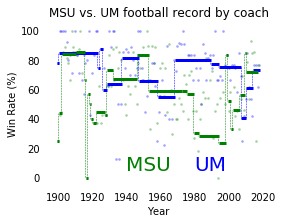

In [20]:
fig = plt.figure(figsize=(4,3))
ax = fig.gca()

for i in [0,1]:
    df = dfs[i]
    by_era = by_eras[i]
    x = df['Year']
    y = 100*df['Win Rate']
    ax.scatter(x,y,color=colors[i],s=3,alpha=0.25)
    
    # Vertical lines
    x = by_era['Year','max'].tolist()
    y = (100*by_era['Win Rate']).tolist()  
    ax.vlines(x[:-1],y[:-1],y[1:],color=colors[i],linewidth=0.5,linestyle='--')
    
ax.hlines(100*by_era_both['Win Rate'],by_era_both['Year','min']-0.5,by_era_both['Year','max']+0.5,
          color=by_era_both['Color'],linewidth=3,picker=5)  
    
ax.set_ylabel('Win Rate (%)')
ax.set_xlabel('Year')

plt.tick_params(bottom=False, left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title('MSU vs. UM football record by coach')
ax.annotate('MSU',xy=(1940,0),xytext=(1940,5),color='g',fontsize=20)
ax.annotate('UM',xy=(1980,0),xytext=(1980,5),color='b',fontsize=20)

plt.show()

Try it with the `zip` feature in Python. This is much more efficient than using the counters! But it does not make it as easy to leave indices out. 

In [41]:
indices =[0]

[colors[i] for i in indices]

['b']

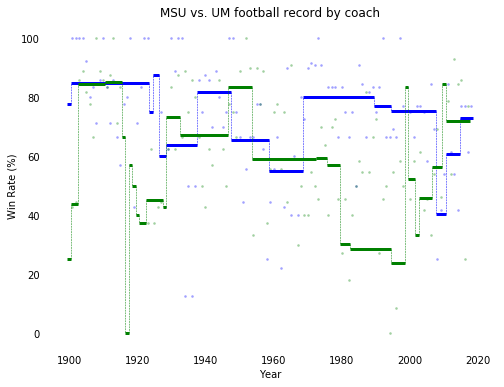

In [67]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ixs =[0,1]


for df, by_era, color in zip([dfs[i] for i in ixs],
                             [by_eras[i] for i in ixs],
                             [colors[i] for i in ixs]):
    x = df['Year']
    y = 100*df['Win Rate']
    ax.scatter(x,y,color=color,s=3,alpha=0.25)
    
    # Vertical lines
    x = (by_era['Year','max']+0.5).tolist()
    y = (100*by_era['Win Rate']).tolist()  
    ax.vlines(x[:-1],y[:-1],y[1:],color=color,linewidth=0.5,linestyle='--')
 
    ax.hlines(100*by_era['Win Rate'], 
              by_era['Year','min']-0.5, 
              by_era['Year','max']+0.5,
              color = color, linewidth=3, picker=5)

ax.set_ylabel('Win Rate (%)')
ax.set_xlabel('Year')

plt.tick_params(bottom=False, left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title('MSU vs. UM football record by coach')
#ax.annotate('MSU',xy=(1940,0),xytext=(1940,5),color='g',fontsize=20)
#ax.annotate('UM',xy=(1980,0),xytext=(1980,5),color='b',fontsize=20)

plt.show()

Something about adding the annotation makes the figure tiny now. Hmm. 

In [177]:
plt.savefig('MSU_vs_UM.png')

# Try interactivity

In [110]:
%matplotlib notebook

<IPython.core.display.Javascript object>


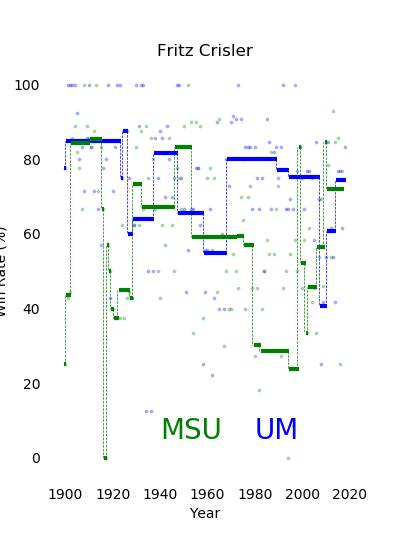

7

In [179]:
fig = plt.figure(figsize=(4,3))
ax = fig.gca()

for i in [0,1]:
    df = dfs[i]
    by_era = by_eras[i]
    x = df['Year']
    y = 100*df['Win Rate']
    ax.scatter(x,y,color=colors[i],s=3,alpha=0.25)
    
    # Vertical lines
    x = by_era['Year','max'].tolist()
    y = (100*by_era['Win Rate']).tolist()  
    ax.vlines(x[:-1],y[:-1],y[1:],color=colors[i],linewidth=0.5,linestyle='--')
    
ax.hlines(100*by_era_both['Win Rate'],by_era_both['Year','min']-0.5,by_era_both['Year','max']+0.5,
          color=by_era_both['Color'],linewidth=3,picker=5)  
    
ax.set_ylabel('Win Rate (%)')
ax.set_xlabel('Year')

plt.tick_params(bottom=False, left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title('MSU vs. UM football record by coach')
ax.annotate('MSU',xy=(1940,0),xytext=(1940,5),color='g',fontsize=20)
ax.annotate('UM',xy=(1980,0),xytext=(1980,5),color='b',fontsize=20)
    
def onpick(event):
    idx = event.ind[0]
    text = by_era_both.loc[idx,'Coach'][0]
    ax.set_title(text)
plt.gcf().canvas.mpl_connect('pick_event', onpick)